# **Annotations and entities stats**
---

In [74]:
# Imports
import os
import json

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

%matplotlib inline

This Jupyter Notebook processes and analyses annotation data from JSON files. Below is an overview of the workflow, key variables, and their purposes.

### **Workflow overview**

**A) Process annotation files**: 
- Extracts data from JSON files and organizes it by tags.
- Saves the processed data into separate CSV files for each tag.


**B) Generate summary**: 
- Creates a summary CSV with total occurrences of each tag and their percentages across different sources (e.g., Figshare, Zenodo, OSF).


**C) Visualizations**: 
- Bar plots for total occurrences of tags.
- Grouped bar plots for tag percentages by source.
- Histograms for the distribution of annotations per file.
- DisplaCy visualisation of the text with the most MOL annotations.

## **A) Process annotation files**

- Extracts data from JSON files and organizes it by tags.
- Saves the processed data into separate CSV files for each tag.
---

In [66]:
# Constants
TAGS = ["MOL", "SOFT", "STIME", "TEMP", "FFM"]
ANNOTATIONS_FOLDER = "../annotations/"

In [67]:
def process_annotation_file(filename:str, tag_data:dict, TAGS:list, ANNOTATIONS_FOLDER:str) -> None:
    """
    Processes a single annotation JSON file and updates tag_data dict.

    Args:
        filename (str): Name of the JSON file.
        tag_data (dict): Dict containing lists for each tag.
        TAGS (list): List of expected tag strings.
        ANNOTATIONS_FOLDER (str): Path to the folder with the files.
    """
    filepath = os.path.join(ANNOTATIONS_FOLDER, filename)

    with open(filepath, "r", encoding="utf-8") as f:
        data = json.load(f)

    # Extract text and entity annotations
    annotation_entry = data["annotations"][0]
    text = annotation_entry[0]
    entities = annotation_entry[1]["entities"]

    # Stats on text
    file_base = os.path.splitext(filename)[0]
    char_count = len(text)
    word_count = len(text.split())

    # Count how many times each tag appears
    tag_counts = {tag: 0 for tag in TAGS}
    for start, end, label in entities:
        if label in tag_counts:
            tag_counts[label] += 1

    # Add the row to the correct tag bucket
    for tag in TAGS:
        tag_data[tag].append({
            "File name": file_base,
            "Number of characters": char_count,
            "Number of words": word_count,
            "Number of annotations": tag_counts[tag]
        })

In [68]:
# Store rows in a list of dicts per tag
tag_data = {tag: [] for tag in TAGS}

# Process all "real" annotation files
for filename in os.listdir(ANNOTATIONS_FOLDER):
    if filename.endswith(".json") and filename.count("_") == 1:
        process_annotation_file(filename, tag_data, TAGS, ANNOTATIONS_FOLDER)

# Save each tag's data to a separate CSV
for tag in TAGS:
    df = pd.DataFrame(tag_data[tag])

    # Sort by "File name" or "Number of annotations" or "Number of characters" or "Number of words"
    df = df.sort_values(by="File name") 

    df.to_csv(f"../results/outputs/real_annotations_{tag}.csv", index=False)

print("One CSV file generated per tag.")

One CSV file generated per tag.


## **B) Generate summary** 
- Creates a summary CSV with total occurrences of each tag and their percentages across different sources (e.g., Figshare, Zenodo, OSF).
---

In [ ]:
def generate_tag_presence_summary_csv(annotations_folder, tags, output_csv_path):
    """
    Generates a summary CSV with one row per tag and columns:
    Tag, Total occurrences, Figshare %, Zenodo %, OSF %

    Percentage = % of files for a given source that contain at least one annotation with the tag.
    """
    # Track total occurrences of tags
    total_counts = defaultdict(int)

    # Track how many files each source has
    source_file_counts = defaultdict(int)

    # Track in how many files each tag appeared at least once per source
    source_tag_hits = {source: defaultdict(int) for source in ["figshare", "zenodo", "osf"]}

    # Loop through files
    for filename in os.listdir(annotations_folder):
        if filename.endswith(".json") and filename.count("_") == 1:
            source = filename.split("_")[0].lower()
            if source not in source_tag_hits:
                continue  # Skip unknown sources

            source_file_counts[source] += 1
            filepath = os.path.join(annotations_folder, filename)

            with open(filepath, "r", encoding="utf-8") as f:
                data = json.load(f)

            annotation_entry = data["annotations"][0]
            entities = annotation_entry[1]["entities"]

            # Count tag occurrences in this file
            seen_tags_in_file = set()
            for start, end, label in entities:
                if label in tags:
                    total_counts[label] += 1
                    seen_tags_in_file.add(label)

            # Update tag hit counters
            for tag in seen_tags_in_file:
                source_tag_hits[source][tag] += 1



    # Build summary rows
    summary_rows = []
    for tag in tags:
        row = {
            "Tag": tag,
            "Total occurrences": total_counts[tag],
            "Figshare %": round(
                (source_tag_hits["figshare"][tag] / source_file_counts["figshare"] * 100)
                if source_file_counts["figshare"] else 0, 2
            ),
            "Zenodo %": round(
                (source_tag_hits["zenodo"][tag] / source_file_counts["zenodo"] * 100)
                if source_file_counts["zenodo"] else 0, 2
            ),
            "OSF %": round(
                (source_tag_hits["osf"][tag] / source_file_counts["osf"] * 100)
                if source_file_counts["osf"] else 0, 2
            )
        }
        summary_rows.append(row)

    # Save to CSV
    df = pd.DataFrame(summary_rows)
    df.to_csv(output_csv_path, index=False)
    print(f"Summary saved to {output_csv_path}")

In [70]:
output_csv_path = "../results/outputs/real_annotations_tag_summary.csv"
generate_tag_presence_summary_csv(ANNOTATIONS_FOLDER, TAGS, output_csv_path)

Summary saved to ../results/outputs/real_annotations_tag_summary.csv


## **C. Visualisations**

1. **Total tag occurrences**: Bar plot showing the total occurrences of each tag across all sources.
2. **Tag percentages by source**: Grouped bar plot showing the percentage of files annotated with each tag for Figshare, Zenodo, and OSF.
3. **Annotation distribution**: Histogram showing the distribution of annotation counts per file for each tag.
4. **DisplaCy visulisation**: DisplaCy visualisation of the text with the most MOL annotations.
---

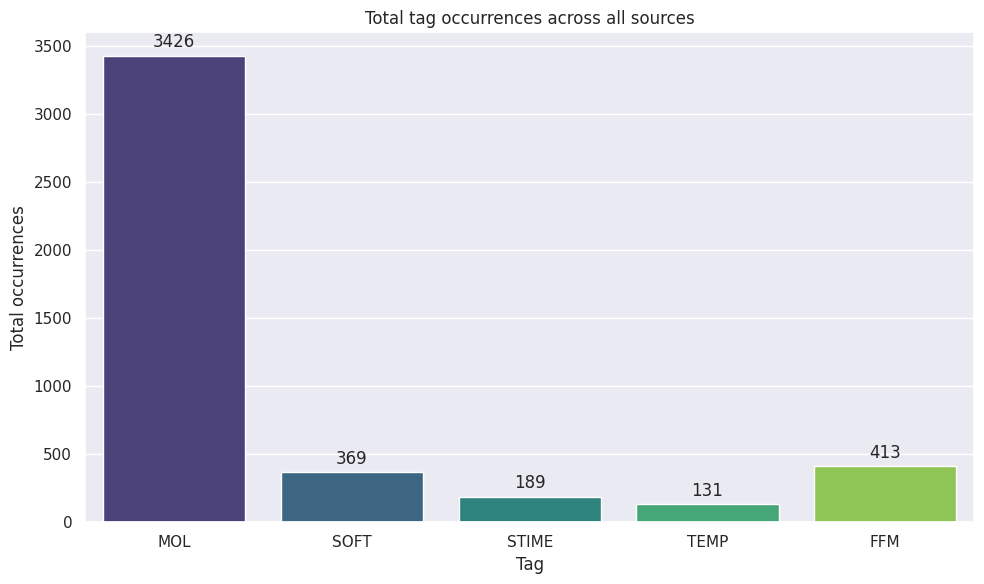

In [82]:
df = pd.read_csv("../results/outputs/real_annotations_tag_summary.csv")

sns.set_theme()

# Bar plot: Total occurrences per tag
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x="Tag", y="Total occurrences", palette="viridis", hue="Tag")

# Add value labels on each bar
for container in ax.containers:
    ax.bar_label(container, padding=3)

plt.title("Total tag occurrences across all sources")
plt.xlabel("Tag")
plt.ylabel("Total occurrences")
plt.tight_layout()
plt.show()

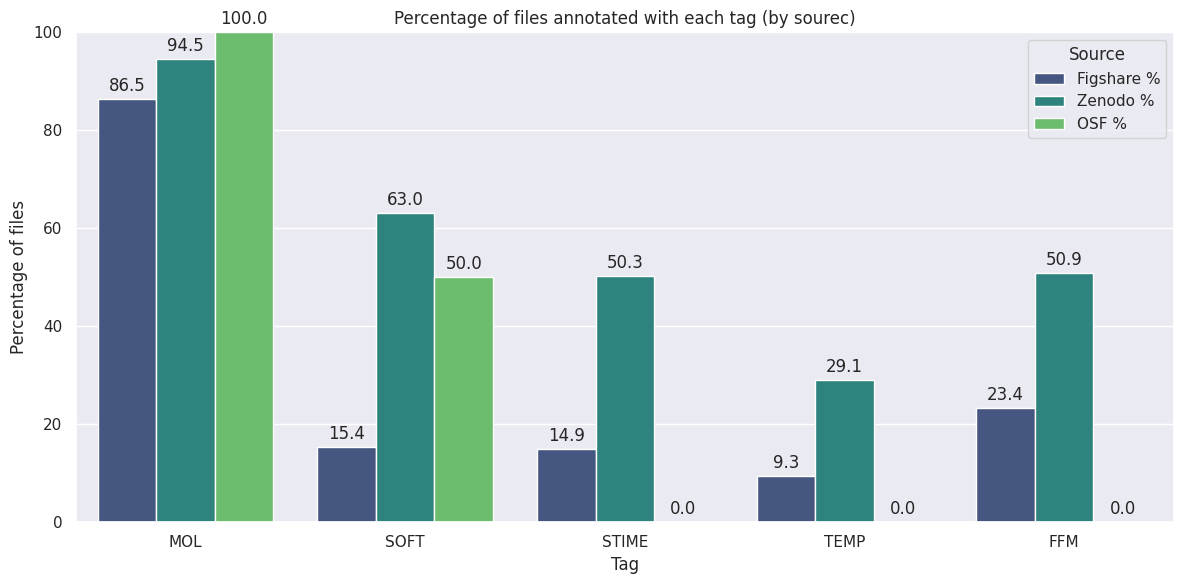

In [72]:
# Melt the % columns for easier grouped bar plotting
df_melted = df.melt(
    id_vars="Tag",
    value_vars=["Figshare %", "Zenodo %", "OSF %"],
    var_name="Source",
    value_name="Percentage"
)

# Grouped bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_melted, x="Tag", y="Percentage", hue="Source", palette="viridis")

# Add value labels on each bar
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", padding=3)

plt.title("Percentage of files annotated with each tag (by sourec)")
plt.xlabel("Tag")
plt.ylabel("Percentage of files")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


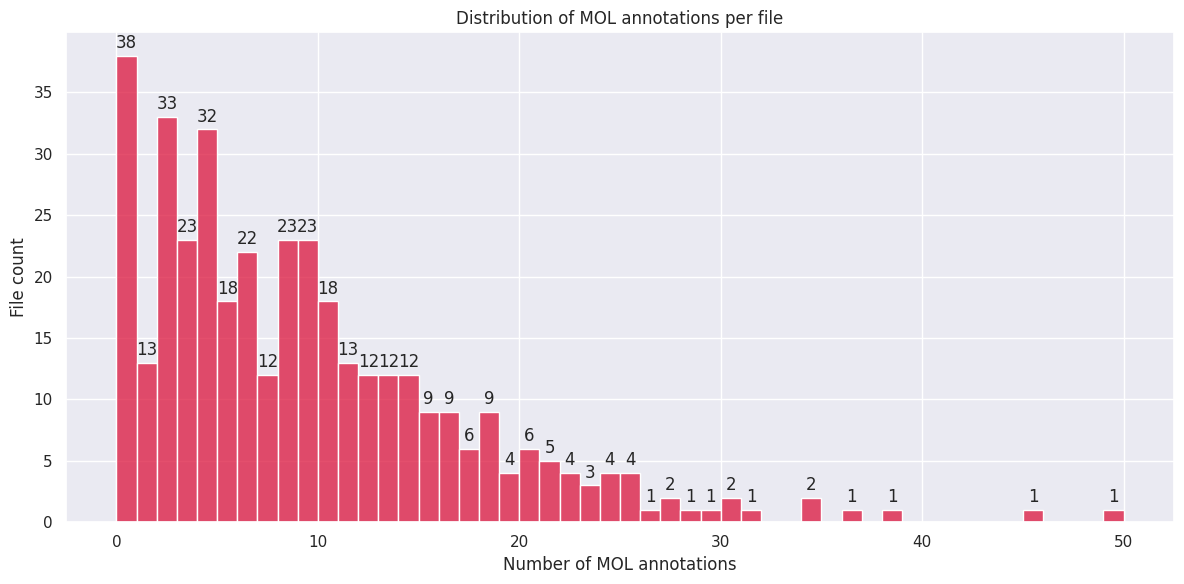

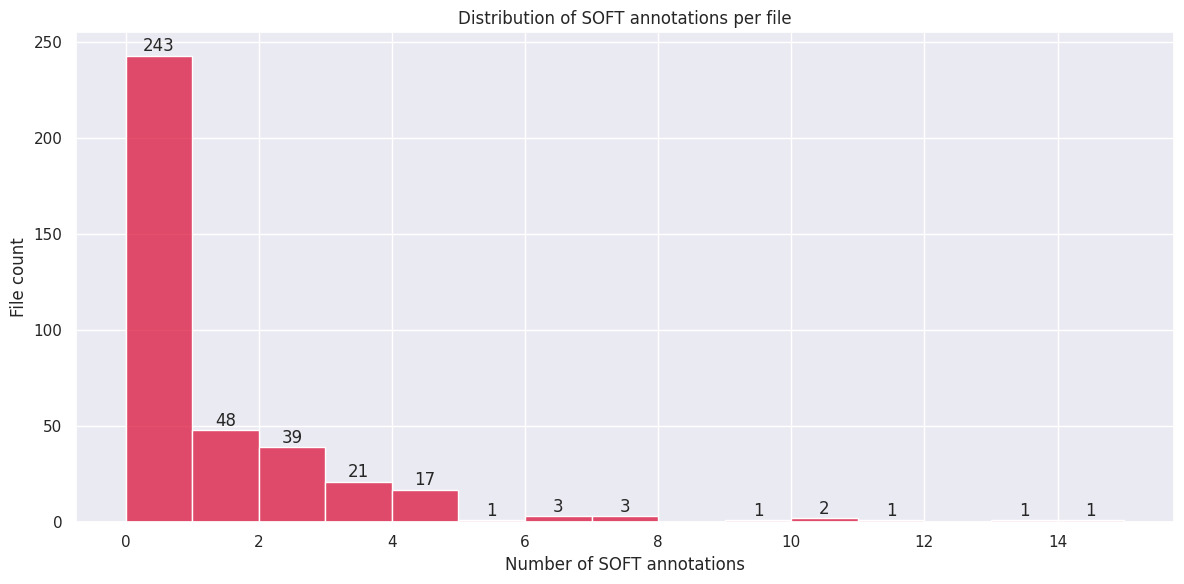

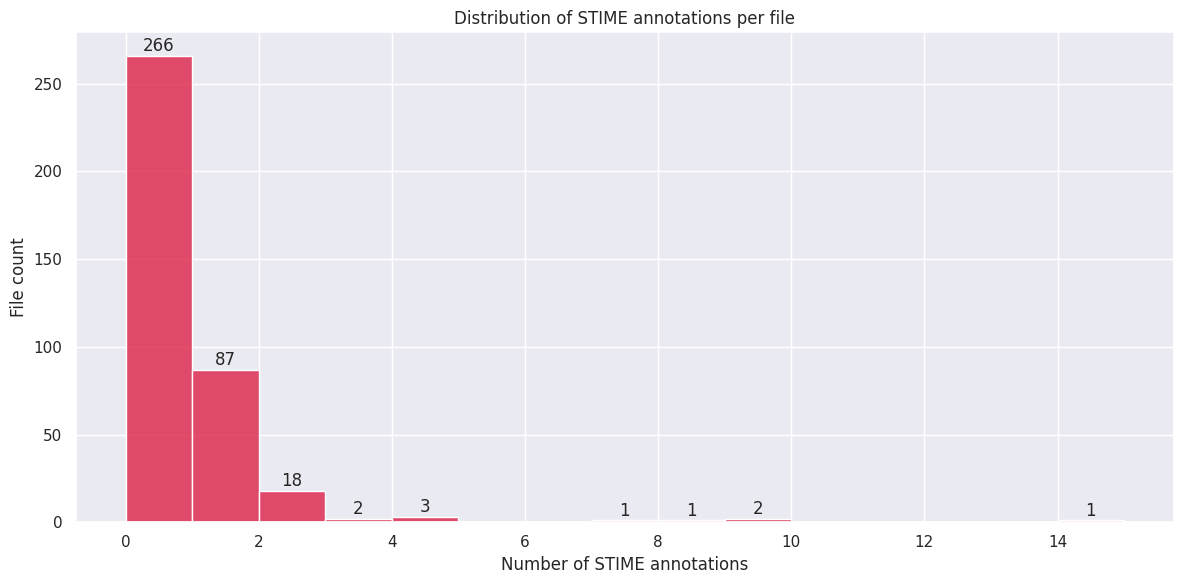

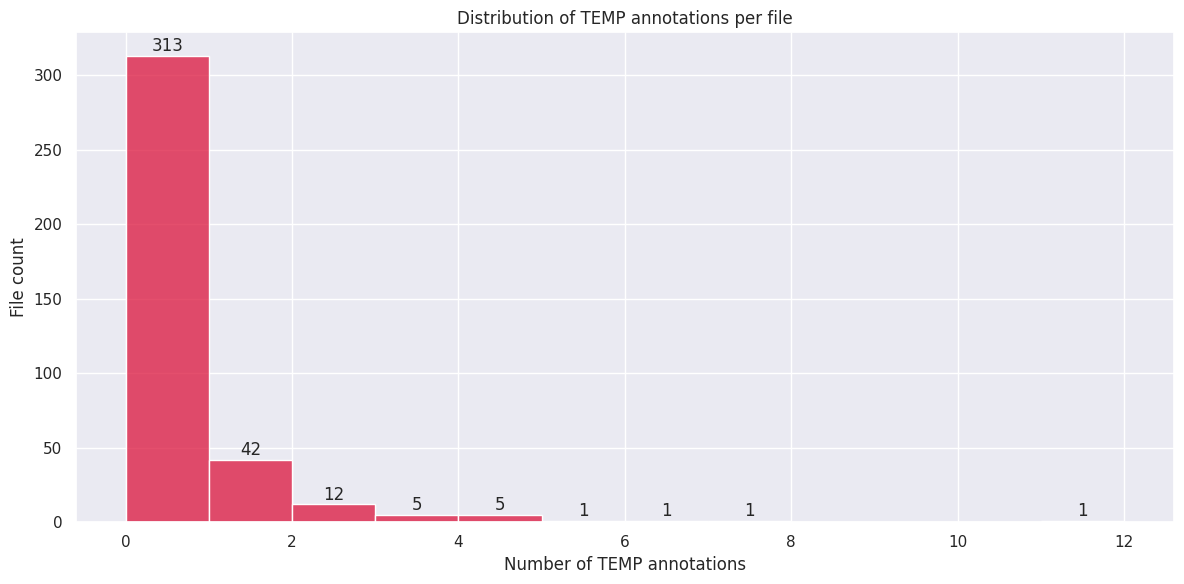

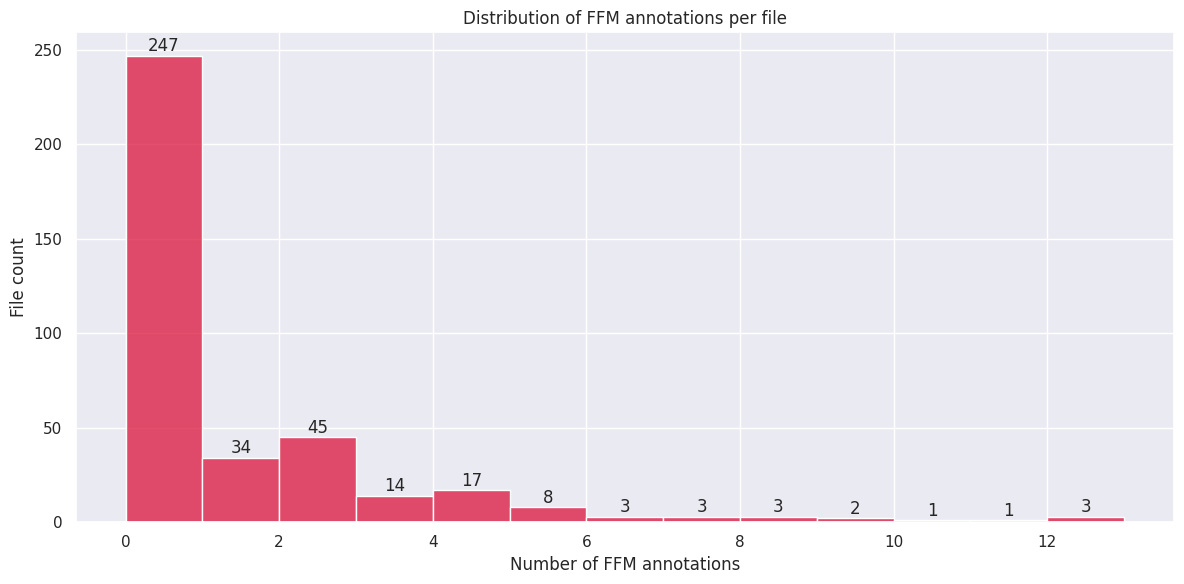

In [73]:
for tag in TAGS:
    df_tag = pd.read_csv(f"../results/outputs/real_annotations_{tag}.csv")


    plt.figure(figsize=(12, 6))
    ax = sns.histplot(data=df_tag, x="Number of annotations", color="crimson", binwidth=1)

    # Add value labels
    for patch in ax.patches:
        height = patch.get_height()
        if height > 0:
            x = patch.get_x() + patch.get_width() / 2
            ax.text(x, height + 0.3, f"{int(height)}", ha="center", va="bottom")

    plt.title(f"Distribution of {tag} annotations per file")
    plt.xlabel(f"Number of {tag} annotations")
    plt.ylabel("File count")
    plt.tight_layout()
    plt.show()

In [84]:
# Load the CSV for MOL annotations
df_mol = pd.read_csv("../results/outputs/real_annotations_MOL.csv")

# Get the row with the max number of annotations
top_file = df_mol.sort_values(by="Number of annotations", ascending=False).iloc[0]

# Extract filename and annotation count
filename = top_file["File name"]
annotation_count = top_file["Number of annotations"]

print(f"File with most MOL annotations: {filename} ({annotation_count} annotations)")


File with most MOL annotations: figshare_11704443 (50 annotations)


In [85]:
from spacy import displacy

def convert_annotations(file_path):
    """
    Convert annotations from the custom format to spaCy's displaCy format.
    
    Parameters:
        file_path (str): Path to the JSON file containing "classes" and "annotations" keys.
        
    Returns:
        List[dict]: A list of dictionaries in the spaCy format.
    """
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    converted = []
    for item in data["annotations"]:
        # Each item is structured as [text, {"entities": [[start, end, label], ...]}]
        text, annotation_info = item
        entities = annotation_info.get("entities", [])
        # Convert each entity to the spaCy dictionary format
        ents = [{"start": start, "end": end, "label": label} for start, end, label in entities]
        converted.append({
            "text": text,
            "ents": ents
        })
    return converted

data = "../annotations/figshare_11704443.json"

# Convert the annotations.
converted_data = convert_annotations(data)
print(converted_data)

colors = {
    "TEMP": "#ffb3ba",
    "SOFT": "#ffffba",
    "STIME": "#baffc9",
    "MOL": "#bae1ff",
    "FFM": "#cdb4db",
}
options = {"colors": colors}

# You now have a list of annotation dictionaries. For visualization with displaCy,
# you can serve a single annotated text or multiple.
displacy.render(converted_data, style="ent", manual=True, options=options)

[{'text': 'Exploring Methamphetamine Nonenantioselectively Targeting Toll-like Receptor 4/Myeloid Differentiation Protein 2 by in Silico Simulations and Wet-Lab Techniques\nMethamphetamine (METH) is one of the highly addictive nonopioid psychostimulants, acting as a xenobiotic-associated molecular pattern (XAMP) to target TLR4 and activate microglia. However, the molecule recognition of METH by innate immune receptor TLR4/MD-2 is not well-understood. METH exists in two enantiomeric forms, and it is unclear whether the TLR4 innate immune recognition with METH is stereoselective. Herein, molecular dynamics (MDs) simulations were performed to dissect the recognition of (+)- METH and ( )- METH by TLR4/MD-2 at the atomic level. Amphetamine (AMPH), which is an analogue of METH, was also investigated for comparison. Computational simulations indicate that METH binds into the interaction interface between MD-2 as well as TLR4* that is from the adjacent copy of TLR4-MD-2, therefore stabilizing 